# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle that contains information on 3 million used cars.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### 1) Business Understanding

**From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.**

When it comes to selling a used car, the most important question is: How much should the car be sold for? This question depends on many factors. For example, certainly a new Lexus is more expensive than a new Toyota. But what if a used Lexus has an odometer reading of 100,000 miles? Would it still be worth more than a Toyota with only 1000 miles on its odometer? 

As we can see, a car's selling price is based off of many different factors. Therefore, some important data about the car that needs to be collected may include: year, manufacturer, model, cylinders, fuel type, transmission, drive, car type, paint color, condition, title status, state/region car is issued in.

The main question we are then trying to answer is:
**Which of the above features are the most important in determining a used car's price?**

### 2) Data Understanding

**After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.**

### Steps taken to understand data:

**Section 2.1:** Import Libraries

**Section 2.2:** Load dataset

**Section 2.3:** Explore dataset by...

- **Section 2.3.1:** examining the output after using .info() attribute on dataset

- **Section 2.3.2:** Visualize number of null values per column in bar graph 

### 2.1) Import Libraries

In [1]:
import plotly.express as px
import numpy as np
from numpy import asarray
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel, RFE
from sklearn.linear_model import Lasso
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
set_config(display="diagram")
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
import category_encoders as ce

### 2.2) Load dataset

In [2]:
vehicles = pd.read_csv('data/vehicles.csv')

### 2.3) Exploring dataset

**2.3.1)** Explore what columns are included in the dataset to help determine car prices and determine the datatypes of each column as well as the number of entries in the dataset

In [3]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

**2.3.2)** Visualizing the number of null values per column

Text(0, 0.5, 'number of null values')

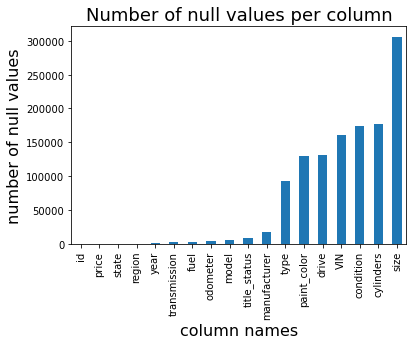

In [4]:
vehicles.isnull().sum().sort_values().plot(kind = 'bar')
plt.title('Number of null values per column', fontsize = 18)
plt.xlabel('column names', fontsize=16)
plt.ylabel('number of null values', fontsize=16)

### 3) Data Preparation

**After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.** 

### Steps taken to prepare/clean data:

**Section 3.1:** Data Cleaning
- **Section 3.1.1:** Eliminate unnecessary data
- **Section 3.1.2:** Convert nominal to numerical values
- **Section 3.1.3:** Ordinal encoding of the "condition" and "title_status" columns
- **Section 3.1.4:** Leave one out encoding

**Section 3.2:** Preliminary Dataset Examination (finding correlation between category features and car price)

**Section 3.3:** Setting up miniature datasets
- **Section 3.3.1:** SF bay area dataframe (higher population)
- **Section 3.3.2:** Gold Country-Modesto-Imperial County dataframe (medium population)
- **Section 3.3.3:** San Luis Obispo-Monterey Bay-Siskiyou County dataframe (lower population)

### 3.1) Data Cleaning

#### 3.1.1) Eliminating unnecessary data

**vehicles_drop** = Will be deleting the "size" column because contains too many null values (as seen from **section 2.3.2**) and also the "id" and "VIN" numbers because these latter columns will not provide any information on price since each car has a different VIN and id number.

**vehicles_clean** = After dropping the unnecessary columns, any remaining rows/columns with null values will also be dropped.

In [5]:
vehicles_drop = vehicles.drop(columns = ['size', 'id', 'VIN'])
vehicles_clean = vehicles_drop.dropna()
vehicles_clean.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al
32,auburn,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,gas,68696.0,clean,other,4wd,pickup,black,al
33,auburn,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,gas,29499.0,clean,other,4wd,pickup,silver,al
34,auburn,35000,2019.0,toyota,tacoma,excellent,6 cylinders,gas,43000.0,clean,automatic,4wd,truck,grey,al
35,auburn,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,gas,17302.0,clean,other,4wd,pickup,red,al


#### 3.1.2) Nominal to numerical values

In the "cylinders" column, rather than recording the number of car cylinders as numerical values, it is currently recorded as strings such as: "6 cylinders" or "8 cylinders". We need to convert these nominal values to numerical values (i.e., 6 or 8).

In [6]:
vehicles_data = vehicles_clean.query('cylinders != "other"')
vehicles_data['cylinders'] = vehicles_data["cylinders"].str.replace(" cylinders","")
vehicles_data['cylinders'] = vehicles_data['cylinders'].astype(str).astype(int)
vehicles_data.info()

C:\Users\Kristen Wang\AppData\Local\Temp\ipykernel_19116\906765576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicles_data['cylinders'] = vehicles_data["cylinders"].str.replace(" cylinders","")
C:\Users\Kristen Wang\AppData\Local\Temp\ipykernel_19116\906765576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicles_data['cylinders'] = vehicles_data['cylinders'].astype(str).astype(int)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 115680 entries, 31 to 426878
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        115680 non-null  object 
 1   price         115680 non-null  int64  
 2   year          115680 non-null  float64
 3   manufacturer  115680 non-null  object 
 4   model         115680 non-null  object 
 5   condition     115680 non-null  object 
 6   cylinders     115680 non-null  int32  
 7   fuel          115680 non-null  object 
 8   odometer      115680 non-null  float64
 9   title_status  115680 non-null  object 
 10  transmission  115680 non-null  object 
 11  drive         115680 non-null  object 
 12  type          115680 non-null  object 
 13  paint_color   115680 non-null  object 
 14  state         115680 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(11)
memory usage: 13.7+ MB


#### 3.1.3) Ordinal Encoding of the "condition" and "title_status" columns
Since the "condition" and "title_status" columns contain nominal datatypes that inherently can be ordered/rank, ordinal encoding will be used to convert these nominal datatypes into numerical datatypes.

For the "condition" column:
- 'salvage' = 0
- 'fair' = 1
- 'good' = 2
- 'excellent' = 3
- 'like new' = 4
- 'new' = 5

In [8]:
scale_mapper_condition = {"salvage":0, "fair":1, "good":2, "excellent":3, "like new":4, "new":5}
vehicles_data['condition_rank'] = vehicles_data['condition'].replace(scale_mapper_condition)
vehicles_data.head()

C:\Users\Kristen Wang\AppData\Local\Temp\ipykernel_19116\2613110568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicles_data['condition_rank'] = vehicles_data['condition'].replace(scale_mapper_condition)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,condition_rank
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6,gas,128000.0,clean,automatic,rwd,truck,black,al,3
32,auburn,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8,gas,68696.0,clean,other,4wd,pickup,black,al,2
33,auburn,34590,2016.0,chevrolet,silverado 1500 double,good,6,gas,29499.0,clean,other,4wd,pickup,silver,al,2
34,auburn,35000,2019.0,toyota,tacoma,excellent,6,gas,43000.0,clean,automatic,4wd,truck,grey,al,3
35,auburn,29990,2016.0,chevrolet,colorado extended cab,good,6,gas,17302.0,clean,other,4wd,pickup,red,al,2


For the "title_status" column:

- 'parts only' = 0
- 'missing' = 1
- 'lien' = 2
- 'salvage' = 3
- 'rebuilt' = 4
- 'clean' = 5

In [9]:
scale_mapper_title = {"parts only":0, "missing":1, "lien":2, "salvage":3, "rebuilt":4, "clean":5}
vehicles_data['title_status_rank'] = vehicles_data['title_status'].replace(scale_mapper_title)
vehicles_data.head()

C:\Users\Kristen Wang\AppData\Local\Temp\ipykernel_19116\3201874552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicles_data['title_status_rank'] = vehicles_data['title_status'].replace(scale_mapper_title)


,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,condition_rank,title_status_rank
31,auburn,15000,2013.0,ford,f-150 xlt,excellent,6,gas,128000.0,clean,automatic,rwd,truck,black,al,3,5
32,auburn,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8,gas,68696.0,clean,other,4wd,pickup,black,al,2,5
33,auburn,34590,2016.0,chevrolet,silverado 1500 double,good,6,gas,29499.0,clean,other,4wd,pickup,silver,al,2,5
34,auburn,35000,2019.0,toyota,tacoma,excellent,6,gas,43000.0,clean,automatic,4wd,truck,grey,al,3,5
35,auburn,29990,2016.0,chevrolet,colorado extended cab,good,6,gas,17302.0,clean,other,4wd,pickup,red,al,2,5


#### 3.1.4) Leave one out encoding
To convert the remaining object datatypes to numerical datatypes, we will use leave-one-out encoding.

In [10]:
encoder = ce.LeaveOneOutEncoder(return_df = True)
vehicles_data_loo = encoder.fit_transform(vehicles_data.drop(columns = ['condition', 'title_status']), vehicles_data['price'])
vehicles_data_loo.head()

,region,price,year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,condition_rank,title_status_rank
31,25736.923077,15000,2013.0,71024.612241,19905.144737,6,53338.593196,128000.0,68672.470963,58873.411665,29928.755274,23657.022827,19137.199242,3,5
32,25403.846154,27990,2012.0,46898.401028,27990.000000,8,53338.470714,68696.0,31390.868268,100813.365618,413546.526555,23656.433311,19127.358333,2,5
33,25234.615385,34590,2016.0,17700.608933,33475.407166,6,53338.408482,29499.0,31390.328920,100813.230929,413546.010325,235780.074012,19122.358333,2,5
34,25224.102564,35000,2019.0,384609.810242,18145.962590,6,53338.404616,43000.0,68672.261082,100813.222562,29927.468935,23626.721058,19122.047727,3,5
35,25352.564103,29990,2016.0,17700.868030,28513.840909,6,53338.451856,17302.0,31390.704830,100813.324803,413546.370121,16599.976080,19125.843182,2,5


### 3.2) Preliminary Dataset Examination

A heatmap is plotted to visualize the correlation between price and the other categorical features: region, year, manufacturer, model, cylinders, fuel, odometer, transmission, drive, type, paint_color, state, condition, title_status

Text(158.09375, 0.5, 'column names')

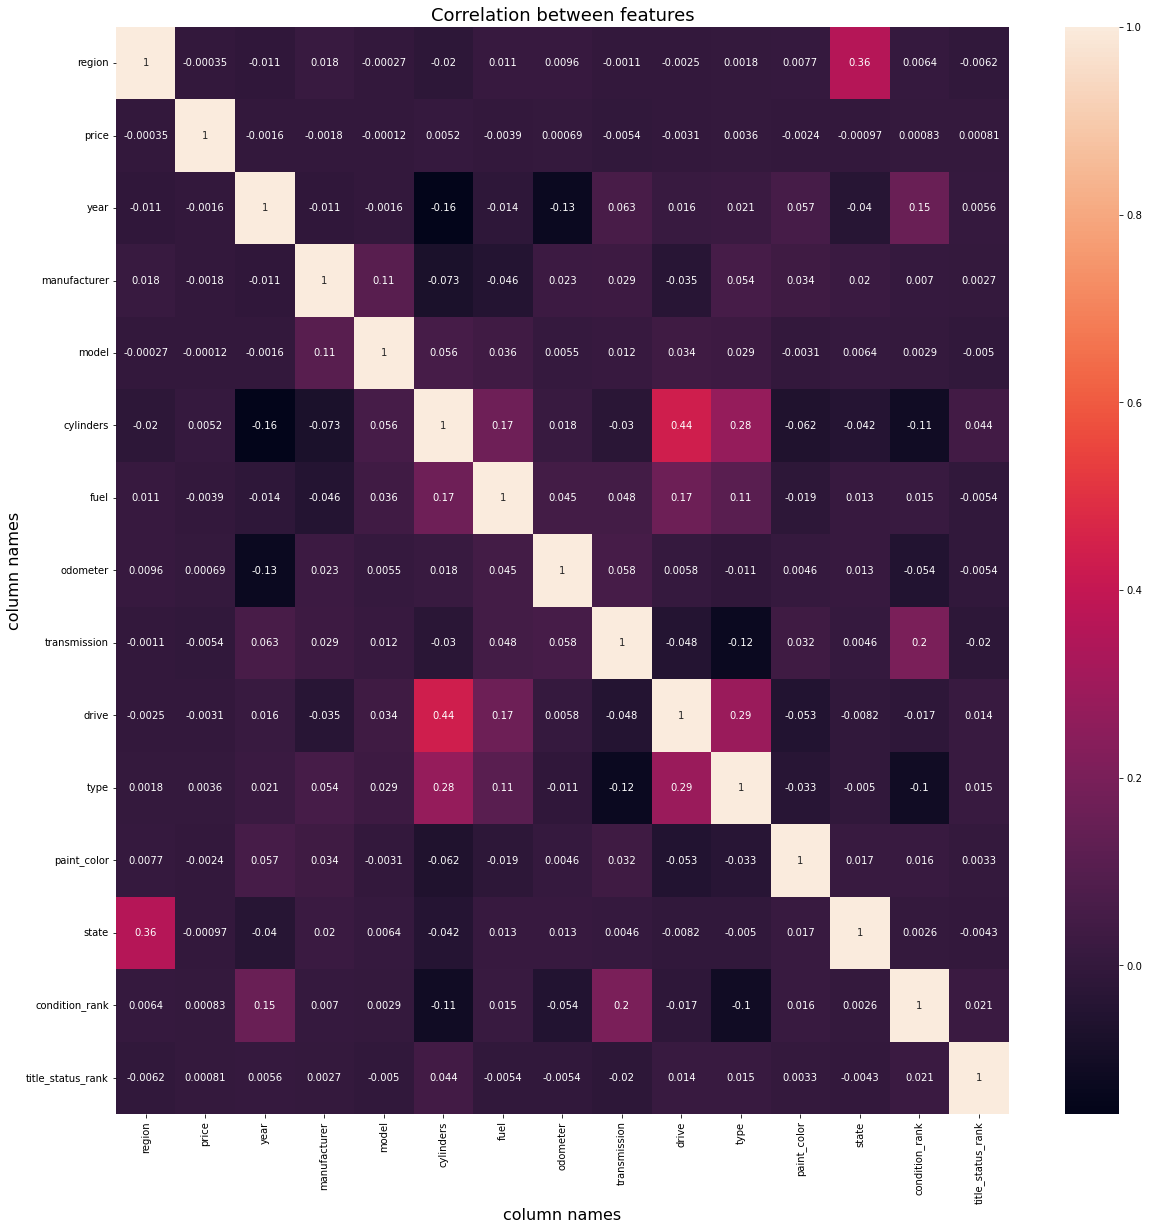

In [11]:
plt.figure(figsize=(20,20))
sns.heatmap(vehicles_data_loo.corr(), annot=True)
plt.title('Correlation between features', fontsize = 18)
plt.xlabel('column names', fontsize=16)
plt.ylabel('column names', fontsize=16)

Based on the above heatmap, there seems to be very little to no correlation between the features and price. This could be because different regions/states have different guidelines when it comes to determining the price of a used car.

### 3.3) Setting up miniature datasets

Because I am from California, I will focus on comparing the car prices/ features that can be used to predict car prices of different regions within California, specifically: Region I (i.e., SF bay area), Region II (i.e., Gold Country/Modesto/Imperial County), and Region III (i.e., San Luis Obispo/Monterey Bay/Siskiyou County). I specifically chose these three regions because they represent different populated regions of CA.


According to Google, Region I (SF bay area) has the highest population in CA while Region III (San Luis Obispo/Monterey Bay/Siskiyou County) has one of the lowest populations in CA. The population of Region II (Gold Country/Modesto/Imperial County) is between that of Region I and III.


The reason why I combine the data of Gold Country with Modesto and Imperial County and the data of San Luis Obispo with Monterey Bay and Siskiyou County is so the overall number of entries for each Region I, II, and III dataset would be approximately the same (about 760 entries).

#### 3.3.1) SF bay area dataframe (higher population)

Using query, I pull up only data from the SF bay area as well as rows with price not equal to zero. 

In [14]:
vehicles_data_SF = vehicles_data.query('region == "SF bay area" and price != 0').drop(columns = ['condition', 'title_status', 'state', 'region'])
vehicles_data_SF.head()

,price,year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,type,paint_color,condition_rank,title_status_rank
60485,25800,2015.0,ford,explorer,6,gas,61351.0,automatic,4wd,SUV,black,3,5
60486,43991,2018.0,mercedes-benz,e-class,6,gas,31481.0,automatic,rwd,coupe,white,3,5
60487,33988,2019.0,toyota,rav4,4,gas,7836.0,automatic,4wd,SUV,red,3,5
60488,23993,2014.0,ford,expedition el,8,gas,101583.0,automatic,4wd,SUV,grey,3,5
60489,18895,2019.0,volkswagen,tiguan,4,gas,24656.0,automatic,fwd,SUV,green,3,5


Then I convert all the remaining nominal values into numerical values using **leave one out encoding** (loo).

In [15]:
vehicles_data_SF_loo = encoder.fit_transform(vehicles_data_SF.drop(columns = ['price']), vehicles_data_SF['price'])
vehicles_data_SF_loo.head()

,year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,type,paint_color,condition_rank,title_status_rank
60485,2015.0,17456.134021,3250.00000,6,16314.885222,61351.0,16146.668821,21315.146341,16636.685714,19298.345070,3,5
60486,2018.0,24711.421053,17157.41906,6,16288.786227,31481.0,16117.281099,20299.970954,22041.516129,20649.777778,3,5
60487,2019.0,13321.292035,20244.00000,4,16303.137733,7836.0,16133.441034,21275.204878,16578.200000,17582.821429,3,5
60488,2014.0,17474.762887,1.00000,8,16317.477762,101583.0,16149.588045,21323.960976,16649.592857,14993.093458,3,5
60489,2019.0,11845.928571,9300.00000,4,16324.791966,24656.0,16157.823910,11962.141956,16686.007143,8995.678571,3,5


#### 3.3.2) Gold Country-Modesto-Imperial County dataframe (medium population)

Using query, I pull up only data from Gold Country, Modesto, and Imperial County as well as rows with price not equal to zero.

In [16]:
medium_region = ['gold country', 'modesto', 'imperial county']
vehicles_data_medium = vehicles_data.query('region in @medium_region and price != 0').drop(columns = ['condition', 'title_status', 'state', 'region'])
vehicles_data_medium.head()

,price,year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,type,paint_color,condition_rank,title_status_rank
28168,3895,2003.0,mercury,sable,6,gas,85750.0,automatic,fwd,sedan,white,3,5
28169,5000,2003.0,ford,explorer sport xlt,6,gas,145553.0,automatic,rwd,SUV,silver,2,5
28178,30590,2016.0,dodge,challenger r/t coupe 2d,8,gas,5937.0,other,rwd,coupe,black,2,5
28180,5850,2003.0,volkswagen,passat,6,gas,67000.0,automatic,4wd,wagon,silver,3,5
28191,1850,1997.0,ford,f150,8,gas,260000.0,automatic,rwd,pickup,silver,1,5


Then I convert all the remaining nominal values into numerical values using **leave one out encoding** (loo).

In [17]:
vehicles_data_medium_loo = encoder.fit_transform(vehicles_data_medium.drop(columns = ['price']), vehicles_data_medium['price'])
vehicles_data_medium_loo.head()

,year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,type,paint_color,condition_rank,title_status_rank
28168,2003.0,15500.000000,14698.208719,6,14025.924609,85750.0,13253.867807,10663.409524,11217.754513,16254.405128,3,5
28169,2003.0,13743.679688,14698.208719,6,14024.352774,145553.0,13252.149300,16575.427350,14232.693878,11992.702128,2,5
28178,2016.0,16409.129032,14698.208719,8,13987.951636,5937.0,32951.403509,16466.068376,19864.313433,16977.176000,2,5
28180,2003.0,6668.142857,9995.000000,6,14023.143670,67000.0,13250.827372,18898.414634,10250.454545,11986.673759,3,5
28191,1997.0,13768.289062,14698.208719,8,14028.833570,260000.0,13257.048212,16588.888889,21868.291139,12015.042553,1,5


#### 3.3.3) San Luis Obispo-Monterey Bay-Siskiyou County dataframe (lower population)

Using query, I pull up only data from San Luis Obispo, Monterey Bay, and Siskiyou County as well as rows with price not equal to zero.

In [18]:
low_region = ['san luis obispo', 'monterey bay', 'siskiyou county']
vehicles_data_low = vehicles_data.query('region in @low_region and price != 0').drop(columns = ['condition', 'title_status', 'state', 'region'])
vehicles_data_low.head()

,price,year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,type,paint_color,condition_rank,title_status_rank
39532,26990,2017.0,nissan,titan single cab sv,8,gas,41335.0,other,4wd,pickup,red,2,5
39534,16995,2017.0,honda,civic sedan lx,4,gas,41179.0,other,fwd,sedan,black,2,5
39535,16995,2015.0,chevrolet,camaro lt,6,gas,95644.0,automatic,rwd,coupe,black,2,5
39536,5895,2007.0,honda,accord sdn,4,gas,152480.0,automatic,fwd,sedan,blue,3,5
39539,34950,2013.0,gmc,sierra 1500,8,gas,67708.0,automatic,4wd,truck,black,3,5


Then I convert all the remaining nominal values into numerical values using **leave one out encoding** (loo).

In [19]:
vehicles_data_low_loo = encoder.fit_transform(vehicles_data_low.drop(columns = ['price']), vehicles_data_low['price'])
vehicles_data_low_loo.head()

,year,manufacturer,model,cylinders,fuel,odometer,transmission,drive,type,paint_color,condition_rank,title_status_rank
39532,2017.0,11581.300000,18106.799476,8,17040.027299,41335.0,29265.393258,24630.639810,26662.173913,19600.924528,2,5
39534,2017.0,9197.892308,16995.000000,4,17054.387931,41179.0,29377.696629,11057.153543,13431.418605,19855.981481,2,5
39535,2015.0,20886.913043,16995.000000,6,17054.387931,95644.0,17333.929160,19487.884746,15593.857143,19855.981481,2,5
39536,2007.0,9368.661538,6209.125000,4,17070.336207,152480.0,17352.215815,11100.854331,13495.953488,13172.061728,3,5
39539,2013.0,20068.500000,11961.000000,8,17028.590517,67708.0,17304.349259,24592.914692,24966.269504,19689.731481,3,5


### 4) Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

### Steps taken to build models from data

**Section 4.1:** Build training and test sets for each of region datasets
- **Section 4.1.1:** SF bay area dataset
- **Section 4.1.2:** Gold Country-Modesto-Imperial County dataset
- **Section 4.1.3:** San Luis Obispo-Monterey Bay-Siskiyou County dataset


**Section 4.2:** Model Fitting: **Ridge Regression** (Use **GridSearchCV** with **10-fold cross-validation** to determine the optimal alpha value to use for each of the three regions' dataset. **Evaluation metric used: MSE**)
- **Section 4.2.1:** SF bay area dataset
- **Section 4.2.2:** Gold Country-Modesto-Imperial County dataset
- **Section 4.2.3:** San Luis Obispo-Monterey Bay-Siskiyou County dataset

### 4.1) Build training and test sets

#### 4.1.1) SF bay area dataset

In [20]:
X_SF = vehicles_data_SF_loo
y_SF = vehicles_data_SF['price']

X_train_SF, X_test_SF, y_train_SF, y_test_SF = train_test_split(X_SF, y_SF, test_size = 0.3, random_state =42)

#### 4.1.2) Gold Country-Modesto-Imperial County dataset

In [21]:
X_medium = vehicles_data_medium_loo
y_medium = vehicles_data_medium['price']

X_train_medium, X_test_medium, y_train_medium, y_test_medium = train_test_split(X_medium, y_medium, test_size = 0.3, random_state = 42)

#### 4.1.3) San Luis Obispo-Monterey Bay-Siskiyou County dataset

In [22]:
X_low = vehicles_data_low_loo
y_low = vehicles_data_low['price']

X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, test_size = 0.3, random_state = 42)

### 4.2) Model Fitting

**Ridge Regression**

After setting up the three different dataframes, machine learning models based off of ridge regression will be used to model the three different datasets to predict car price.

But first, we need to **determine the optimal alpha parameter.**

1) Create an unfit model

In [23]:
scaled_ridge_model = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', Ridge(random_state = 42))
])

2) Create a python dictionary of all the hyperparameters and the alpha values that we want to try out

In [24]:
parameters_to_try = {'ridge__alpha': 10**np.linspace(-5, 4, 100)}

From here, we will use **GridSearchCV** with **10-fold cross-validation** to determine the optimal alpha value to use for each of the three regions' dataset.

#### 4.2.1) SF bay area dataset

Determine optimal alpha value:

In [25]:
model_finder_SF = GridSearchCV(estimator = scaled_ridge_model,
                           param_grid = parameters_to_try,
                           cv = 10)

In [26]:
model_finder_SF.fit(X_train_SF, y_train_SF)
model_finder_SF.best_params_ 

{'ridge__alpha': 43.287612810830616}

Determine model coefficients:

In [27]:
scaled_ridge_alpha_SF = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', Ridge(alpha = 43.287612810830616, random_state = 42))
])

In [28]:
scaled_ridge_alpha_SF.fit(X_train_SF, y_train_SF)

Pipeline(steps=[('scale', StandardScaler()),
                ('ridge', Ridge(alpha=43.287612810830616, random_state=42))])

In [29]:
feature_names_SF = scaled_ridge_alpha_SF[:-1].get_feature_names_out()

coefs_SF = pd.DataFrame(
    scaled_ridge_alpha_SF[-1].coef_,
    columns = ["coefficients"],
    index = feature_names_SF
)

coefs_SF.sort_values('coefficients')

,coefficients
odometer,-7481.745823
transmission,255.513795
paint_color,320.489529
title_status_rank,731.258157
manufacturer,898.276010
type,1027.376932
model,1100.793474
cylinders,1610.353672
condition_rank,1666.492874
year,1746.688281


Evaluation metric: **MSE**

In [30]:
# Training mse
train_mse_SF = mean_squared_error(y_train_SF, scaled_ridge_alpha_SF.predict(X_train_SF))

# Test mse
test_mse_SF = mean_squared_error(y_test_SF, scaled_ridge_alpha_SF.predict(X_test_SF))

print('training mse: ', train_mse_SF)
print('test mse: ', test_mse_SF)

training mse:  122889990.38554807
test mse:  158152669.93544713


#### 4.2.2) Gold Country-Modesto-Imperial County dataset

Determine optimal alpha value:

In [31]:
model_finder_medium = GridSearchCV(estimator = scaled_ridge_model,
                           param_grid = parameters_to_try,
                           cv = 10)

In [32]:
model_finder_medium.fit(X_train_medium, y_train_medium)
model_finder_medium.best_params_ 

{'ridge__alpha': 5336.699231206302}

Determine model coefficients

In [33]:
scaled_ridge_alpha_medium = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', Ridge(alpha = 5336.699231206302, random_state = 42))
])

In [34]:
scaled_ridge_alpha_medium.fit(X_train_medium, y_train_medium)

Pipeline(steps=[('scale', StandardScaler()),
                ('ridge', Ridge(alpha=5336.699231206302, random_state=42))])

In [35]:
feature_names_medium = scaled_ridge_alpha_medium[:-1].get_feature_names_out()

coefs_medium = pd.DataFrame(
    scaled_ridge_alpha_medium[-1].coef_,
    columns = ["coefficients"],
    index = feature_names_medium
)

coefs_medium.sort_values('coefficients')

,coefficients
odometer,-53.058436
title_status_rank,72.145281
paint_color,141.399777
condition_rank,158.252054
fuel,183.477209
cylinders,232.258400
drive,255.182694
manufacturer,261.394523
year,295.770777
type,313.308375


Evaluation metric: **MSE**

In [36]:
# Training mse
train_mse_medium = mean_squared_error(y_train_medium, scaled_ridge_alpha_medium.predict(X_train_medium))

# Test mse
test_mse_medium = mean_squared_error(y_test_medium, scaled_ridge_alpha_medium.predict(X_test_medium))

print('training mse: ', train_mse_medium)
print('test mse: ', test_mse_medium)

training mse:  104326357.72911628
test mse:  166772605.3119569


#### 4.2.3) San Luis Obispo-Monterey Bay-Siskiyou County dataset

Determine optimal alpha value

In [37]:
model_finder_low = GridSearchCV(estimator = scaled_ridge_model,
                           param_grid = parameters_to_try,
                           cv = 10)

In [38]:
model_finder_low.fit(X_train_low, y_train_low)
model_finder_low.best_params_ 

{'ridge__alpha': 100.0}

Determine model coefficients

In [39]:
scaled_ridge_alpha_low = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', Ridge(alpha = 100.0, random_state = 42))
])

In [40]:
scaled_ridge_alpha_low.fit(X_train_low, y_train_low)

Pipeline(steps=[('scale', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, random_state=42))])

In [41]:
feature_names_low = scaled_ridge_alpha_low[:-1].get_feature_names_out()

coefs_low = pd.DataFrame(
    scaled_ridge_alpha_low[-1].coef_,
    columns = ["coefficients"],
    index = feature_names_low
)

coefs_low.sort_values('coefficients')

,coefficients
odometer,-4675.988853
paint_color,133.925934
title_status_rank,288.223584
transmission,885.999041
type,961.176384
condition_rank,1195.590738
manufacturer,1217.981887
cylinders,1731.575939
fuel,1776.411718
drive,1932.020100


Evaluation metric: **MSE**

In [42]:
# Training mse
train_mse_low = mean_squared_error(y_train_low, scaled_ridge_alpha_low.predict(X_train_low))

# Test mse
test_mse_low = mean_squared_error(y_test_low, scaled_ridge_alpha_low.predict(X_test_low))

print('training mse: ', train_mse_low)
print('test mse: ', test_mse_low)

training mse:  93797241.98358962
test mse:  87587413.75037856


### 5) Evaluation

**With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.**

Recall that our **business objective** is to determine a used car's selling price based off of certain features of the car including: year, manufacturer, model, cylinders, fuel type, transmission, drive, car type, paint color, condition, title status, state/region car is issued in.


From section 3.2, I noticed that accounting all car data entries from different regions and states may not result in the best model since different states/regions have different guidelines for how to price a used car. Hence, there is minimal correlation between the considered car features and price.


The difference between the training mse and the test mse is the smallest for Region III dataset (made up of data from regions with lower populations) and the largest difference in mse's is seen for Region II dataset (made up of data from regions with medium populations). This shows that the price of a used car from different regions within the same state (CA) may not be dependent on the same features. In this case, the price of a used car is more correlated with the current dataset features when the car is being sold in more low-populated regions, not medium or higher populated regions. Information of other car features may need to be gathered for better correlation between price and features in higher populated regions.


In fact, in the SF bay area, the top five features with the highest coefficients in magnitude are: odometer, drive, fuel, year, and condition.


In the Gold Country-Modesto-Imperial County region, the top five features are: model, transmission, type, year, and manufacturer.


In the San Luis Obispo-Monterey Bay-Imperial County region, the top five features are: odometer, year, model, drive, fuel.


It is important to note that odometer is inversely correlated with price, meaning that as the odometer reading increases, the price of the used car decreases. 

### 6) Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

To determine a used car's sale price, it is important to first note the region/state the car is from. Below, I will use different regions of CA as an example:


If the car is from a populated area like SF bay area,CA, then a high odometer reading will decrease the price of the used car but features that would maximize the price of a used car are when:
- drive = 4wd
- fuel = diesel
- year = 2021
- condition = new


If the car is from a medium populated area like Gold Country-Modesto-Imperial County, CA, then the car's model, transmission, type, year, and manufacturer become important factors in determining a used car's price. A used car's price can be maximized if:
- the transmission is neither automatic nor manual
- year = 2021
- type = other
- manufacturer = Porsche
- model = el camino


If the car is from a low populated area like San Luis Obispo-Monterey Bay-Siskiyou County, CA, then a high odometer reading will decrease the price of the used car but features that would increase the price of the car is if:
- year = 2021
- model = Benz
- drive = 4wd
- fuel = other


From the above information, one can see that the number one most important feature to consider, no matter which region/state the car is sold in, is the year of the car. Additionally, price is more correlated to the dataset features in the low-populated dataset than in the medium/higher populated dataset. **Therefore, to improve the model for used-car price prediction in more populated regions, I recommend to gather information of other car features, specifically features that are valued more by residents of higher populated regions.**